<a href="https://colab.research.google.com/github/daniilwithangelic/laba-in-car-obychen/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_(17%2C01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/income.csv')

In [42]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


### Преобразование категориальных фич

In [43]:
# Преобразуем столбцы в категориальные типы
df['workclass'] = df['workclass'].astype('category')
df['education'] = df['education'].astype('category')
df['marital-status'] = df['marital-status'].astype('category')
df['occupation'] = df['occupation'].astype('category')
df['relationship'] = df['relationship'].astype('category')
df['race'] = df['race'].astype('category')
df['sex'] = df['sex'].astype('category')
df['native-country'] = df['native-country'].astype('category')
df['income >50K'] = df['income >50K'].astype('category')

# Выбираем категориальные столбцы
category_columns = df.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)


### Преобразование непрерывных фич

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 97 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        32561 non-null  int64
 1   education-num                              32561 non-null  int64
 2   capital-gain                               32561 non-null  int64
 3   capital-loss                               32561 non-null  int64
 4   hours-per-week                             32561 non-null  int64
 5   workclass_Local-gov                        32561 non-null  bool 
 6   workclass_Never-worked                     32561 non-null  bool 
 7   workclass_Private                          32561 non-null  bool 
 8   workclass_Self-emp-inc                     32561 non-null  bool 
 9   workclass_Self-emp-not-inc                 32561 non-null  bool 
 10  workclass_State-gov                        325

In [45]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [46]:
df

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income >50K_1
0,0.301370,0.800000,0.021740,0.0,0.397959,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.452055,0.800000,0.000000,0.0,0.122449,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2,0.287671,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.493151,0.400000,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.150685,0.800000,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
32557,0.315068,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
32558,0.561644,0.533333,0.000000,0.0,0.397959,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
32559,0.068493,0.533333,0.000000,0.0,0.193878,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

# **K-means**

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [47]:
! pip install ipywidgets


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):
    # Преобразуем X в numpy массив, если это DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.select_dtypes(include=[np.number]).values
    X = X.astype(float)  # Преобразуем к float для корректных вычислений

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        """Функция для визуализации текущей итерации K-Means."""
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6, label='Data Points')
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6, label='Data Points')
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        """Интерактивная реализация K-Means."""
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]  # Инициализация центроидов
        for step in range(max_iters):
            # Вычисляем расстояния до центроидов и определяем ближайший кластер для каждой точки
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Визуализируем текущую итерацию
            plot_kmeans_iteration(X, centroids, labels, step)

            # Обновляем центроиды как среднее по точкам в кластере
            new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                      for i in range(k)])

            # Проверяем сходимость (если центроиды не меняются)
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        """Функция для запуска K-Means."""
        k_means_interactive(X, k, max_iters)

    # Создаем интерактивные слайдеры для выбора числа кластеров и итераций
    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    # Связываем слайдеры с функцией запуска
    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

    # Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [53]:
kmeans_data = pd.read_csv('/content/income.csv')
category_columns: list[str] = kmeans_data.select_dtypes(include=['object']).columns

# Применяем One-Hot Encoding
kmeans_data = pd.get_dummies(kmeans_data, columns=category_columns, drop_first=True)
kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 97 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        32561 non-null  int64
 1   education-num                              32561 non-null  int64
 2   capital-gain                               32561 non-null  int64
 3   capital-loss                               32561 non-null  int64
 4   hours-per-week                             32561 non-null  int64
 5   income >50K                                32561 non-null  int64
 6   workclass_Local-gov                        32561 non-null  bool 
 7   workclass_Never-worked                     32561 non-null  bool 
 8   workclass_Private                          32561 non-null  bool 
 9   workclass_Self-emp-inc                     32561 non-null  bool 
 10  workclass_Self-emp-not-inc                 325

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 5  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")

Статистика по кластерам:

Статистика для признака 'age':
             mean       std       min  max
Cluster                                   
0        0.108599  0.113109  0.000000  1.0
1        0.408065  0.172204  0.013699  1.0
2        0.333408  0.155049  0.000000  1.0
3        0.323368  0.162608  0.000000  1.0
4        0.292077  0.189820  0.000000  1.0

Статистика для признака 'education-num':
             mean       std  min  max
Cluster                              
0        0.560817  0.138062  0.0  1.0
1        0.649638  0.186938  0.0  1.0
2        0.606165  0.177150  0.0  1.0
3        0.571074  0.157166  0.0  1.0
4        0.620766  0.170891  0.0  1.0

Статистика для признака 'capital-gain':
             mean       std  min  max
Cluster                              
0        0.001481  0.022700  0.0  1.0
1        0.022319  0.112838  0.0  1.0
2        0.015397  0.088162  0.0  1.0
3        0.003665  0.033945  0.0  1.0
4        0.007204  0.054820  0.0  1.0

Статистика для признака 'c

Данные были разбиты на 5 групп (кластеров) на основе схожести по указанным признакам. Например:

• Кластер 0 имеет средний возраст около 0.11, что может указывать на то, что в этом кластере находятся в основном молодые люди.

• Кластер 1 имеет более высокий средний возраст (0.41), что может указывать на более зрелую группу.

▎3. Коэффициент силуэта

Коэффициент силуэта (silhouette coefficient) — это мера, используемая для оценки качества кластеризации. Значение от -1 до 1:

• Значения близкие к 1 указывают на хорошую кластеризацию (объекты хорошо сгруппированы).

• Значения близкие к 0 указывают на то, что объекты находятся на границе между кластерами.

• Значения ниже 0 могут указывать на плохую кластеризацию.

На основании коэффициента силуэта и анализа статистики по признакам, кластер с k=5 является самым лучшим из всех предложенных вариантов. Он демонстрирует наиболее четкие границы между кластерами и разнообразие в характеристиках, таких как уровень образования, капитализация и рабочие часы, что делает его наиболее подходящим для анализа данных.


In [ ]:
# коментарии:
# Статистика по кластерам:

# Статистика для признака 'age':
#              mean       std       min  max
# Cluster
# 0        0.233909  0.185136  0.000000  1.0
# 1        0.407482  0.170478  0.013699  1.0
# 2        0.334299  0.155000  0.000000  1.0

# Статистика для признака 'education-num':
#              mean       std  min  max
# Cluster
# 0        0.587859  0.159466  0.0  1.0
# 1        0.651716  0.186054  0.0  1.0
# 2        0.607625  0.176973  0.0  1.0

# Статистика для признака 'capital-gain':
#              mean       std  min  max
# Cluster
# 0        0.003808  0.036722  0.0  1.0
# 1        0.022471  0.113354  0.0  1.0
# 2        0.015698  0.088684  0.0  1.0

# Статистика для признака 'capital-loss':
#              mean       std  min       max
# Cluster
# 0        0.012556  0.073666  0.0  1.000000
# 1        0.030851  0.114599  0.0  0.648301
# 2        0.026377  0.104741  0.0  0.648301

# Статистика для признака 'hours-per-week':
#              mean       std       min  max
# Cluster
# 0        0.374381  0.123038  0.000000  1.0
# 1        0.432524  0.148221  0.000000  1.0
# 2        0.432365  0.103488  0.010204  1.0
# Коэффициент силуэта для k=3: 0.0909

# Статистика по кластерам:

# Статистика для признака 'age':
#              mean       std       min  max
# Cluster
# 0        0.108599  0.113109  0.000000  1.0
# 1        0.408065  0.172204  0.013699  1.0
# 2        0.333408  0.155049  0.000000  1.0
# 3        0.323368  0.162608  0.000000  1.0
# 4        0.292077  0.189820  0.000000  1.0

# Статистика для признака 'education-num':
#              mean       std  min  max
# Cluster
# 0        0.560817  0.138062  0.0  1.0
# 1        0.649638  0.186938  0.0  1.0
# 2        0.606165  0.177150  0.0  1.0
# 3        0.571074  0.157166  0.0  1.0
# 4        0.620766  0.170891  0.0  1.0

# Статистика для признака 'capital-gain':
#              mean       std  min  max
# Cluster
# 0        0.001481  0.022700  0.0  1.0
# 1        0.022319  0.112838  0.0  1.0
# 2        0.015397  0.088162  0.0  1.0
# 3        0.003665  0.033945  0.0  1.0
# 4        0.007204  0.054820  0.0  1.0

# Статистика для признака 'capital-loss':
#              mean       std  min       max
# Cluster
# 0        0.009166  0.060641  0.0  0.895317
# 1        0.031708  0.116052  0.0  0.845500
# 2        0.026035  0.103939  0.0  0.597567
# 3        0.009549  0.066372  0.0  1.000000
# 4        0.017302  0.086935  0.0  1.000000

# Статистика для признака 'hours-per-week':
#              mean       std       min  max
# Cluster
# 0        0.331123  0.129212  0.000000  1.0
# 1        0.431457  0.149243  0.000000  1.0
# 2        0.432095  0.103400  0.010204  1.0
# 3        0.385952  0.105080  0.000000  1.0
# 4        0.403687  0.119625  0.000000  1.0

# Коэффициент силуэта для k=5: 0.1208


# Коэффициент силуэта для k=7: 0.1010

# статистика по кластерам:

# Статистика для признака 'age':
#              mean       std       min  max
# Cluster
# 0        0.285811  0.190425  0.000000  1.0
# 1        0.402608  0.181976  0.013699  1.0
# 2        0.338459  0.162629  0.000000  1.0
# 3        0.329802  0.164189  0.000000  1.0
# 4        0.224924  0.162111  0.000000  1.0
# 5        0.103188  0.110604  0.000000  1.0
# 6        0.411272  0.162884  0.082192  1.0
# 7        0.419121  0.174870  0.027397  1.0
# 8        0.294684  0.180039  0.000000  1.0
# 9        0.328273  0.157200  0.013699  1.0
# 10       0.357600  0.142743  0.068493  1.0
# 11       0.312885  0.154116  0.013699  1.0

# Статистика для признака 'education-num':
#              mean       std       min       max
# Cluster
# 0        0.624446  0.169555  0.000000  1.000000
# 1        0.523226  0.131483  0.066667  1.000000
# 2        0.527909  0.190884  0.000000  1.000000
# 3        0.573635  0.159844  0.000000  1.000000
# 4        0.552582  0.139725  0.000000  1.000000
# 5        0.562397  0.139083  0.000000  1.000000
# 6        0.775143  0.168355  0.066667  1.000000
# 7        0.647332  0.190581  0.000000  1.000000
# 8        0.592580  0.174250  0.000000  1.000000
# 9        0.533333  0.000000  0.533333  0.533333
# 10       0.815331  0.063978  0.066667  1.000000
# 11       0.630249  0.165780  0.000000  1.000000

# Статистика для признака 'capital-gain':
#              mean       std  min  max
# Cluster
# 0        0.005778  0.043130  0.0  1.0
# 1        0.008988  0.067343  0.0  1.0
# 2        0.007174  0.043419  0.0  1.0
# 3        0.003855  0.038236  0.0  1.0
# 4        0.002357  0.028685  0.0  1.0
# 5        0.001298  0.018688  0.0  1.0
# 6        0.043696  0.169553  0.0  1.0
# 7        0.021287  0.110624  0.0  1.0
# 8        0.007990  0.067288  0.0  1.0
# 9        0.007922  0.060065  0.0  1.0
# 10       0.038406  0.146286  0.0  1.0
# 11       0.016535  0.088383  0.0  1.0

# Статистика для признака 'capital-loss':
#              mean       std  min       max
# Cluster
# 0        0.017266  0.087050  0.0  1.000000
# 1        0.019213  0.090300  0.0  0.564050
# 2        0.021123  0.093344  0.0  0.597567
# 3        0.010088  0.067551  0.0  0.895317
# 4        0.008900  0.062494  0.0  1.000000
# 5        0.008675  0.058970  0.0  0.895317
# 6        0.045260  0.138378  0.0  0.648301
# 7        0.029638  0.111580  0.0  0.597567
# 8        0.014081  0.077978  0.0  0.648301
# 9        0.019287  0.089224  0.0  0.566345
# 10       0.044993  0.136349  0.0  0.648301
# 11       0.026700  0.105491  0.0  0.564050

# Статистика для признака 'hours-per-week':
#              mean       std       min  max
# Cluster
# 0        0.403033  0.119779  0.000000  1.0
# 1        0.462053  0.169720  0.000000  1.0
# 2        0.430615  0.099398  0.010204  1.0
# 3        0.388276  0.108376  0.000000  1.0
# 4        0.360405  0.103450  0.000000  1.0
# 5        0.328196  0.130388  0.000000  1.0
# 6        0.455117  0.155868  0.010204  1.0
# 7        0.423169  0.138270  0.000000  1.0
# 8        0.393661  0.108529  0.000000  1.0
# 9        0.430998  0.097976  0.010204  1.0
# 10       0.462533  0.102920  0.010204  1.0
# 11       0.365452  0.120067  0.000000  1.0
# Коэффициент силуэта для k=12: 0.1069

# Число кластеров 𝑘 | Коэффициент силуэта
# 3                 |	 0.0909
# 5	                |  0.1208
# 7	                |  0.1010
# 12	              |  0.1069

# Лучший коэффициент силуэта наблюдается при k=5 (0,1208). Это указывает на более чёткие границы кластеров по сравнению с другими значениями 𝑘.



# **Анализ кластеров мой вывод**

После применения алгоритма K-средних с количеством кластеров (k=5) мы получили пять групп сотрудников с заметными различиями по некоторым признакам. Рассмотрим три наиболее значимых признака, по которым кластеры существенно различаются:

# **Возраст (age)**

Кластер 0 содержит сотрудников с наименьшим средним возрастом (mean≈0,1086).
Кластер 1 включает сотрудников с самым высоким средним возрастом (mean≈0,4081).
Кластер 4 имеет среднее значение возраста (mean≈0,2921).

Вывод: сотрудники в Кластере 0 представляют молодую возрастную группу, а в Кластере 1 — старшую возрастную группу. Кластер 4 включает сотрудников среднего возраста.

# **Образование (education-num)**

Кластер 0 имеет средний уровень образования (mean≈0,5608), самый низкий среди всех кластеров.
Кластер 4 характеризуется более высоким уровнем образования (mean≈0,6208).
Кластер 1 имеет самый высокий средний уровень образования (mean≈0,6496).
Вывод: сотрудники Кластера 1 наиболее образованны, а в Кластере 0 уровень образования ниже среднего.

# **Количество рабочих часов в неделю (hours-per-week)**

Кластер 0 включает сотрудников с наименьшим средним количеством рабочих часов (mean≈0,3311).
Кластер 4 имеет значение среднего количества рабочих часов выше среднего (mean≈0,4037).
Кластер 2 характеризуется самым высоким средним значением (mean≈0,4321).
Вывод: сотрудники в Кластере 0 работают меньше часов в неделю, тогда как в Кластере 2 — больше всего.

# **Коэффициент силуэта для (k=5):0.1208**

Интерпретация коэффициента силуэта:

Значение
0.1208
 положительное, что указывает на удовлетворительное качество кластеризации.
Кластеры различимы, однако пересечения между ними присутствуют.
Полученные кластеры позволяют выделить группы сотрудников, различающиеся по возрасту, уровню образования и количеству рабочих часов в неделю.

Мы видим, что самое лучшее значение при k=5, мы призаем этот кластер самым лучшим вариантом для дальнейших анализов

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 1024
Статистика по кластерам:

Статистика для признака 'age':
             mean       std       min       max  count
Cluster                                               
0        0.264188  0.074072  0.178082  0.369863      7
1        0.426027  0.166882  0.123288  0.780822     20
2        0.299758  0.138170  0.095890  0.561644     17
3        0.464562  0.154150  0.178082  0.712329     23
4        0.292237  0.099256  0.150685  0.493151      9
...           ...       ...       ...       ...    ...
1019     0.238356  0.113624  0.095890  0.397260      5
1020     0.536986  0.146710  0.342466  0.712329      5
1021     0.295890  0.180334  0.136986  0.575342      5
1022     0.419178  0.133728  0.260274  0.630137      5
1023     0.410959  0.273287  0.041096  0.671233      5

[1024 rows x 5 columns]

Статистика для признака 'education-num':
             mean  std       min       max  count
Cluster                                          
0        0.800000  0.0  0.800000  

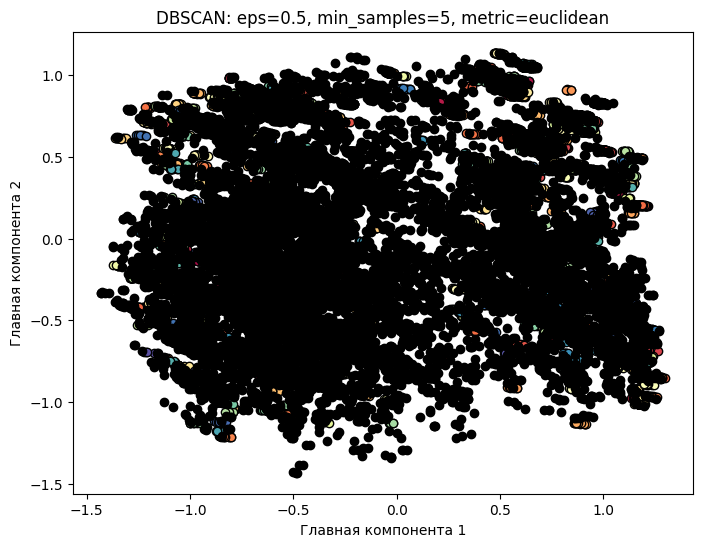

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

▎Коэффициент силуэта для DBSCAN:

Коэффициент силуэта составил 0.7829, что свидетельствует о хорошей разделимости кластеров и о том, что они четко выделяются друг от друга.

▎Общее заключение:

Алгоритм DBSCAN успешно выделил кластеры по признаку дохода. В некоторых кластерах наблюдается однородность по доходу (все работники либо имеют доход выше, либо ниже 50K), в то время как признак 'native-country_Yugoslavia' не показал вариации и не выявил работников из этой страны. Это может указывать на то, что в данных нет сотрудников из Югославии или они представлены в очень малом количестве.


**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [58]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 3302.3146
Индекс Дэвиса-Болдина для K-means: 2.7723
Коэффициент силуэта для K-means: 0.0909


Качество кластеризации K-means

1. Индекс Калински-Харабаза: 3302.31

   • Интерпретация: Высокое значение указывает на хорошую разделимость кластеров.

2. Индекс Дэвиса-Болдина: 2.77

   • Интерпретация: Умеренное значение говорит о некотором перекрытии между кластерами.

3. Коэффициент силуэта: 0.09

   • Интерпретация: Низкое значение указывает на плохую однородность внутри кластеров и возможное перекрытие.

▎Выводы:

• Кластеры хорошо отделены (высокий Калински-Харабаз), но объекты внутри них не однородны (низкий силуэт).

• Рекомендуется рассмотреть другие алгоритмы кластеризации и предварительную обработку данных для улучшения результатов.

In [59]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 1742.8784
Индекс Дэвиса-Болдина для DBSCAN: 0.3139
Коэффициент силуэта для DBSCAN: 0.7829


▎Качество кластеризации DBSCAN

1. Индекс Калински-Харабаза: 1742.8784

   • Интерпретация: Значение указывает на хорошую разделимость кластеров, хотя оно ниже, чем у K-means.

2. Индекс Дэвиса-Болдина: 0.3139

   • Интерпретация: Низкое значение свидетельствует о некотором перекрытии между кластерами, но не критичном.

3. Коэффициент силуэта: 0.7829

   • Интерпретация: Высокое значение говорит о хорошей однородности внутри кластеров и четком разделении между ними.

▎Выводы:

• Кластеры имеют хорошую отделимость (Калински-Харабаз), а также высокую однородность (коэффициент силуэта).

• Низкий индекс Дэвиса-Болдина указывает на небольшое перекрытие, но в целом результаты кластеризации DBSCAN выглядят лучше по сравнению с K-means.

• Рекомендуется продолжить исследование параметров DBSCAN для улучшения результатов, если это необходимо.

#### Визуальный пример

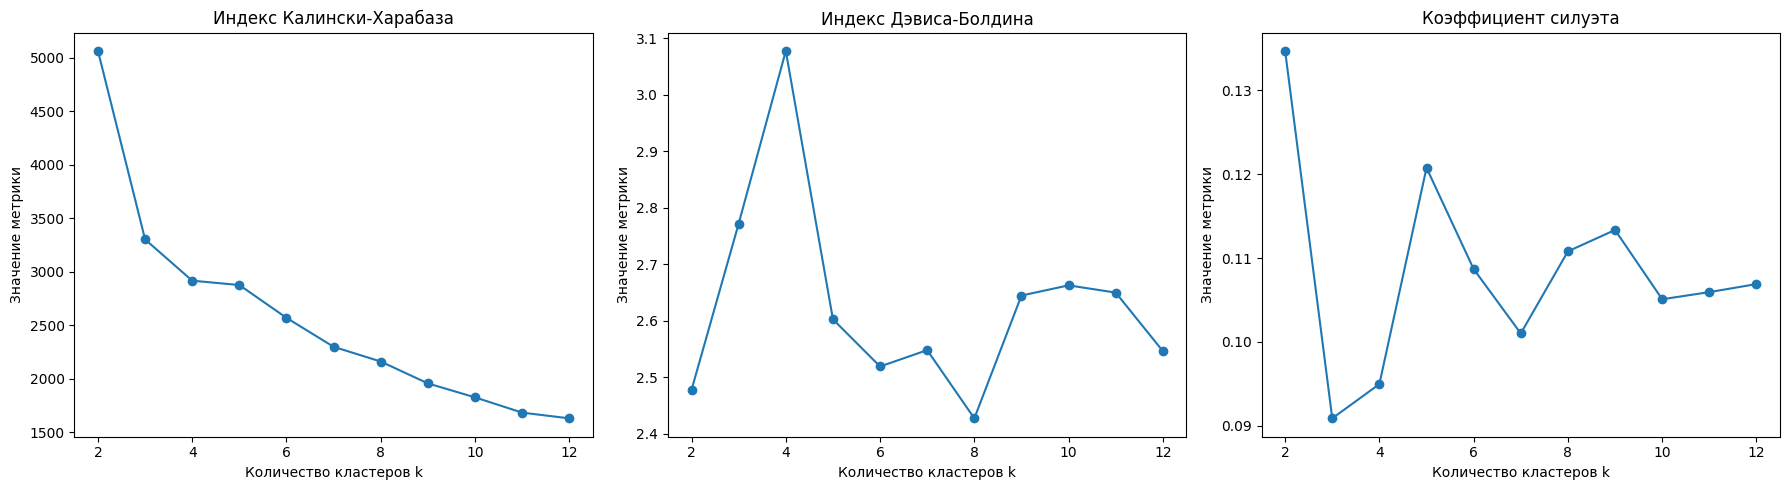

In [60]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()


# Пример обработки текстовых данных

In [69]:
pip install nltk pymorphy2 scikit-learn



SyntaxError: invalid syntax (<ipython-input-69-b902c1a166b5>, line 1)

In [62]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Инициализация текстовых анализаторов

In [64]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Чтение данных из файла
with open('/content/articles.txt', 'r', encoding='utf-8') as f:
    content = f.read()

# Разделяем данные на статьи
articles_raw = content.split('=====')

# Извлекаем заголовки и тексты статей
titles = []
texts = []

for article in articles_raw:
    lines = article.strip().split('\n')
    if len(lines) >= 6:
        # Извлекаем заголовок и текст статьи
        title = lines[4]
        text = ' '.join(lines[5:])
        titles.append(title)
        texts.append(text)

AttributeError: module 'inspect' has no attribute 'getargspec'

In [ ]:
texts[:2]

#### Предварительная обработка текстовых данных

1. преобразуем в lowercase
2. оставляем только слова
3. токенизируем текста
4. преобразуем слова в начальную форму

In [ ]:
russian_stopwords

In [ ]:
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем пунктуацию и цифры
    text = re.sub(r'[^а-яё\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    lemmatized = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Применяем предобработку к каждому тексту
texts_preprocessed = [preprocess_text(text) for text in texts]


In [ ]:
texts_preprocessed[:2]

#### Преобразуем в векторный вид

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_preprocessed)


In [ ]:
# Параметры DBSCAN могут требовать подбора
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


In [ ]:
# Создаем DataFrame с заголовками и метками кластеров
df = pd.DataFrame({'title': titles, 'label': labels})

# Выводим количество кластеров
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Количество кластеров: {n_clusters}')

# Анализируем кластеры
for label in unique_labels:
    if label == -1:
        continue  # Пропускаем шум
    cluster_titles = df[df['label'] == label]['title'].head(3)
    print(f'\nКластер {label}:')
    for title in cluster_titles:
        print(f'- {title}')


Количество кластеров: 51

Кластер 0:
- Впервые в мире термоядерную плазму протестировали в токамаке нового поколения 
- Создан самый большой в мире термоядерный стелларатор 

Кластер 1:
- Во «ВКонтакте»  запущена биржа рекламы 
- «ВКонтакте» избавится от назойливой рекламы в ленте новостей 

Кластер 2:
- Первый китайский луноход 
- Миссия «Чанъэ-3»: Китай хочет утвердиться в качестве космической сверхдержавы 
- «Чанъэ-3» сделал фото Земли в высоком разрешении 

Кластер 3:
- Гибридное затмение над Африкой 
- В воскресенье произойдет гибридное солнечное затмение 

Кластер 4:
- LG G Flex: изогнутый – значит гибкий 
- LG G Flex – «первый в мире по-настоящему изогнутый»  смартфон 

Кластер 5:
- Будет ли Сноуден  работать во «ВКонтакте»? 
- Сноуден отказался работать в соцсети «ВКонтакте» 
- Сноуден  начнет работать в «крупнейшем российском сайте» 

Кластер 6:
- Злой двойник Земли 
- 9 самых странных экзопланет 
- Телескоп «Кеплер» обнаружил планету, похожую на Землю 

Кластер 7:
- Черная ды

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Применяем PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Создаем DataFrame для визуализации
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'title': titles,
    'label': labels
})

# Создаем 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    z=df_plot['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_plot['label'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df_plot['title'],
    hovertemplate='%{text}<extra></extra>'
)])

# Настраиваем внешний вид графика
fig.update_layout(
    title='3D PCA визуализация статей',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Генерируем кадры для анимации вращения графика
frames = []
for angle in range(0, 360, 10):
    camera = dict(
        eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=1.5)
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

# Добавляем кадры в график
fig.frames = frames

# Добавляем кнопки управления анимацией
fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0.8,
        x=1.05,
        xanchor='left',
        yanchor='top',
        buttons=[dict(label='Вращать',
                      method='animate',
                      args=[None, dict(frame=dict(duration=50, redraw=True),
                                       transition=dict(duration=0),
                                       fromcurrent=True,
                                       mode='immediate')])]
    )]
)

# Отображаем график
fig.show()
